In [55]:
%matplotlib inline

# Demonstration of OVRO-LWA Stage 3 M&C

## Python APIs
1. ARX (Larry, Rick)
2. F-engine (Jack)
3. X-engine (Jack)
4. Data capture (Jayce)

## Setup

Set up scripts often run on lxdlwacr. lxdlwagpu03 is also ok.

Jack recommends:
1. Program and initialize SNAPs with lwa_snap_feng_init.py
2. Fire up the GPU pipelines with lwa352-start-pipeline.sh (possibly killing existing pipelines first)
3. Watch X-engine log files until things are running with names `<hostname>.<pipeline_id>.log`
4. Trigger correlator output with lwa352_arm_correlator.py
5. Currently, success means 10s integrations sent to lxdlwagpu03 for capture by Jayce's bifrost pipeline. Good logging:

`2021-07-08 20:33:17 [INFO    ] CORR OUTPUT >> Sending complete for time_tag 318652171392122880 in 2.12 seconds (381714432 Bytes; 1.44 Gb/s)`

Note: 
* F-engine "-t" flag injects test vector. 
* See also video recording of demo.


## Breakdown
1. lwa352-stop-pipeline.sh # essentially just a `killall lwa352-pipeline.py`

In [66]:
cd ~/ovro_data_recorder/


/home/ubuntu/ovro_data_recorder


In [67]:
import matplotlib.pyplot as plt
import numpy as np

from common import ETCD_HOST, ETCD_PORT  #  works in ovro_data_recorder directory

## etcd level M&C

In [68]:
import etcd3
le = etcd3.client(ETCD_HOST, ETCD_PORT)

# e.g., print a key:
# -- "le.get('/cmd/arx/2')"
# -- "le.get('/mon/snap/1')"

## ARX M&C

* Repo forthcoming "lwa-pyutils"

In [69]:
import lwautils.lwa_arx as arx

ma = arx.ARX()

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwautils/conf/etcdConfig.yml


In [70]:
ma.get_chan_cfg(21, 0)

{'sig_on': False,
 'narrow_lpf': False,
 'narrow_hpf': True,
 'first_atten': 31.5,
 'second_atten': 31.5,
 'dc_on': False}

## F-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

In [71]:
from lwa_f import snap2_fengine
lwa_f = snap2_fengine.Snap2Fengine('snap01')

2021-07-13 21:51:57,360 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-07-13 21:51:57,743 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [72]:
for block in sorted(lwa_f.blocks.keys()):
    print(block)

adc
autocorr
corr
delay
eq
eqtvg
eth
fpga
input
noise
packetizer
pfb
powermon
reorder
sync


In [73]:
lwa_f.eqtvg.print_status()

tvg_enabled: False


In [96]:
lwa_f.input.print_status()

mean00: -4.0044403076171875
mean01: 1.0017242431640625
mean02: -1.9198760986328125
mean03: 0.0
mean04: 2.0027618408203125
mean05: 1.9979400634765625
mean06: -0.0007476806640625
mean07: 0.817108154296875
mean08: -2.000030517578125
mean09: -1.0
mean10: 0.4691009521484375
mean11: 0.815643310546875
mean12: -1.9993438720703125
mean13: 0.3193359375
mean14: -0.999542236328125
mean15: -2.0081634521484375
mean16: -3.1215667724609375
mean17: -1.3577880859375
mean18: 0.499664306640625
mean19: 1.0000457763671875
mean20: 0.775665283203125
mean21: -1.0000152587890625
mean22: -0.032470703125
mean23: -0.08148193359375
mean24: -3.0
mean25: 1.498565673828125
mean26: 0.658111572265625
mean27: 0.0002899169921875
mean28: -0.9962921142578125
mean29: -1.3021240234375
mean30: 1.7685699462890625
mean31: 0.1537322998046875
mean32: -0.0001068115234375
mean33: 1.0
mean34: -1.0
mean35: -1.889007568359375
mean36: -0.519866943359375
mean37: -2.0364532470703125
mean38: -1.9996795654296875
mean39: 1.0
mean40: -0.64105

2021-07-13 21:59:44,055 - lwa_f.blocks.block:snap01 - INFO - input - Getting histogram for stream 4


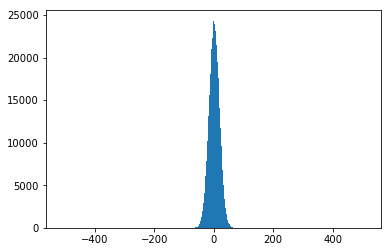

In [116]:
lwa_f.input.plot_histogram(4)

In [117]:
specs = lwa_f.autocorr.get_new_spectra()   # before 4-bit scaling/quantization

In [118]:
len(specs), len(specs[0])

(16, 4096)

In [120]:
autospec = lwa_f.corr.get_new_corr(4, 4)  # 8-channel average, normalized by accumulated time/chans

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


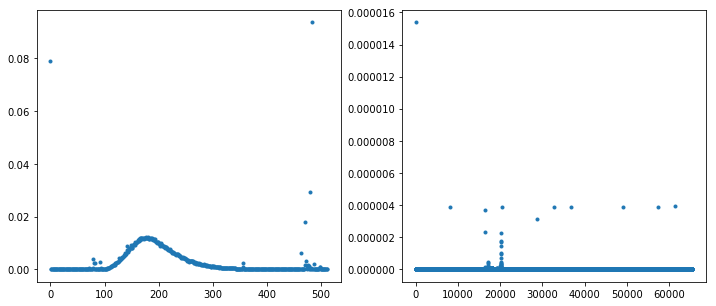

In [121]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,5))
ax0.plot(autospec, '.')
ax1.plot(np.concatenate(specs), '.')

In [124]:
np.savez('spec_auto_4.npz', autospec)

## X-engine M&C

* Repo https://github.com/realtimeradio/caltech-lwa
* python install "control_sw"

"/mon/corr/xeng/<hostname>/pipeline/<pid>/corr" or "beamform"

In [86]:
from lwa352_pipeline_control import Lwa352PipelineControl
lwa_x = Lwa352PipelineControl(pipeline_id=0, etcdhost='10.42.0.64', host='lxdlwagpu02')

In [87]:
lwa_x.corr.get_bifrost_status()

{'pid': 31378,
 'name': 'Corr',
 'cmd': '/home/ubuntu/anaconda3/bin/python /home/ubuntu/anaconda3/bin/lwa352-pipeline.py --nobeamform --ibverbs --gpu 0 --pipelineid 0 --useetcd --etcdhost etcdv3service.sas.pvt --ip 10.41.0.33 --bufgbytes 4 --cores 1,2,3,4,5,6,7,7,7,7,7,7,7 --logfile /home/ubuntu/lxdlwagpu02.0.log ',
 'core': 5,
 'acquire': 6.818771362304688e-05,
 'process': 0.011490821838378906,
 'reserve': 1.2636184692382812e-05,
 'total': 0.011571645736694336,
 'gbps': 225.85204404893352,
 'time': 1626213225.1944742,
 'time_tag': 1,
 'sync_time': 0,
 'seq0': 38908387367040,
 'chan0': 576,
 'nchan': 192,
 'system_nchan': 3072,
 'fs_hz': 196000000,
 'sfreq': 13781250.0,
 'bw_hz': 4593750.0,
 'nstand': 352,
 'npol': 2,
 'complex': 'True',
 'nbit': 4,
 'acc_len': 2400,
 'stats': {'xgpu_acc_len': 480,
  'state': 'running',
  'update_pending': False,
  'last_cmd_proc_time': 1626211772.2429035,
  'start_time': 38908387367040,
  'acc_len': 2400,
  'curr_sample': 38908421890080,
  'new_start_

In [88]:
lwa_x.corr_acc.get_bifrost_status()

{'pid': 31378,
 'name': 'CorrAcc',
 'cmd': '/home/ubuntu/anaconda3/bin/python /home/ubuntu/anaconda3/bin/lwa352-pipeline.py --nobeamform --ibverbs --gpu 0 --pipelineid 0 --useetcd --etcdhost etcdv3service.sas.pvt --ip 10.41.0.33 --bufgbytes 4 --cores 1,2,3,4,5,6,7,7,7,7,7,7,7 --logfile /home/ubuntu/lxdlwagpu02.0.log ',
 'core': 6,
 'acquire': 0.08531641960144043,
 'process': 0.08074450492858887,
 'reserve': 0.00023055076599121094,
 'total': 0.1662914752960205,
 'gbps': 0.0,
 'time': 1626213228.203517,
 'time_tag': 1,
 'sync_time': 0,
 'seq0': 38908387703040,
 'chan0': 576,
 'nchan': 192,
 'system_nchan': 3072,
 'fs_hz': 196000000,
 'sfreq': 13781250.0,
 'bw_hz': 4593750.0,
 'nstand': 352,
 'npol': 2,
 'complex': 'True',
 'nbit': 4,
 'acc_len': 240000,
 'upstream_acc_len': 2400,
 'stats': {'state': 'running',
  'update_pending': False,
  'last_cmd_proc_time': 1626211786.2582088,
  'start_time': 38908387703040,
  'acc_len': 240000,
  'curr_sample': 38908421958240,
  'new_start_time': 389

In [89]:
from astropy import time
time.Time.now().unix

1626213231.258558

## Data capture M&C

In [91]:
import mcs #  works in ovro_data_recorder directory
from common import LWATime #  works in ovro_data_recorder directory

from datetime import timedelta, datetime

c = mcs.Client()
mcs_id = 'drvs19'   # data recorder visibilities slow server 19 (end of x-engine IP address)

In [92]:
# start
t_now = LWATime(datetime.utcnow() + timedelta(seconds=15), format='datetime', scale='utc')
mjd_now = int(t_now.mjd)
mpm_now = int((t_now.mjd - mjd_now)*86400.0*1000.0)
r = c.send_command(mcs_id, 'start', start_mjd=mjd_now, start_mpm=mpm_now)

In [93]:
# stop
r = c.send_command(mcs_id, 'stop', stop_mjd='now', stop_mpm=0)

In [94]:
r


(True,
 {'sequence_id': 'e0463440e42411ebbabd3cecef0c4411',
  'timestamp': 1626213259.7620645,
  'status': 'success',
  'response': {'filename': '/home/ubuntu/data'}})